## Import Library

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import product
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix


## Data Preprocessing

In [22]:
# Load dataset
df = pd.read_csv("winequality-red.csv", delimiter=';')

# Tambahkan kolom ID unik biar gampang tracking
df.insert(0, "ID", range(1, len(df) + 1))

# Filter hanya fitur yang relevan untuk fuzzy model
df_filtered = df[["ID", "alcohol", "volatile acidity", "sulphates"]].copy()


## Fuzzification

In [23]:
def fuzzify_alcohol(val):
    rendah = 1 if val <= 8.0 else (1 - (val - 8.0) / (9.5 - 8.0) if val <= 9.5 else 0)
    sedang = (val - 9.0) / (10.0 - 9.0) if 9.0 < val <= 10.0 else (11.0 - val) / (11.0 - 10.0) if 10.0 < val < 11.0 else 0
    tinggi = 1 if val >= 12.5 else (0 if val <= 10.5 else (val - 10.5) / (12.5 - 10.5))
    return {"rendah": rendah, "sedang": sedang, "tinggi": tinggi}

def fuzzify_volatile_acidity(val):
    rendah = 1 if val <= 0.3 else (1 - (val - 0.3) / (0.5 - 0.3) if val <= 0.5 else 0)
    sedang = (val - 0.4) / (0.6 - 0.4) if 0.4 < val <= 0.6 else (0.8 - val) / (0.8 - 0.6) if 0.6 < val < 0.8 else 0
    tinggi = 1 if val >= 0.9 else (0 if val <= 0.7 else (val - 0.7) / (0.9 - 0.7))
    return {"rendah": rendah, "sedang": sedang, "tinggi": tinggi}

def fuzzify_sulphates(val):
    rendah = 1 if val <= 0.4 else (1 - (val - 0.4) / (0.6 - 0.4) if val <= 0.6 else 0)
    sedang = (val - 0.5) / (0.7 - 0.5) if 0.5 < val <= 0.7 else (0.9 - val) / (0.9 - 0.7) if 0.7 < val < 0.9 else 0
    tinggi = 1 if val >= 1.0 else (0 if val <= 0.8 else (val - 0.8) / (1.0 - 0.8))
    return {"rendah": rendah, "sedang": sedang, "tinggi": tinggi}


## Inference Rules (Mamdani & Sugeno)

In [24]:
def mamdani_inference(fz_alcohol, fz_va, fz_sulphates):
    levels = ["rendah", "sedang", "tinggi"]
    rules = []

    for a in levels:
        for va in levels:
            for s in levels:
                α = min(fz_alcohol[a], fz_va[va], fz_sulphates[s])

                # Aturan fuzzy logika
                if a == "tinggi" and va == "rendah":
                    out = "tinggi"
                elif a == "tinggi":
                    out = "sedang"
                elif a == "sedang" and va == "rendah":
                    out = "sedang"
                elif a == "sedang" and va == "sedang" and s == "sedang":
                    out = "sedang"
                elif a == "sedang":
                    out = "rendah"
                elif a == "rendah" and va == "rendah" and s == "tinggi":
                    out = "sedang"
                else:
                    out = "rendah"

                rules.append((out, α))

    return {
        "rendah": max([α for out, α in rules if out == "rendah"], default=0),
        "sedang": max([α for out, α in rules if out == "sedang"], default=0),
        "tinggi": max([α for out, α in rules if out == "tinggi"], default=0),
    }

def sugeno_infer(fz_alcohol, fz_va, fz_sulphates):
    levels = ["rendah", "sedang", "tinggi"]
    rules = []

    def output_value(a, va, s):
        if a == "tinggi" and va == "rendah":
            return 90
        elif a == "tinggi":
            return 70
        elif a == "sedang" and va == "rendah":
            return 65
        elif a == "sedang" and va == "sedang" and s == "sedang":
            return 60
        elif a == "sedang":
            return 50
        elif a == "rendah" and va == "rendah" and s == "tinggi":
            return 55
        else:
            return 40

    for a in levels:
        for va in levels:
            for s in levels:
                α = min(fz_alcohol[a], fz_va[va], fz_sulphates[s])
                z = output_value(a, va, s)
                rules.append((α, z))

    numerator = sum([w * z for w, z in rules])
    denominator = sum([w for w, _ in rules])
    return numerator / denominator if denominator != 0 else 0


## Defuzzification


In [25]:
def output_membership(x, label):
    if label == "rendah":
        return 1 if x <= 30 else (1 - (x - 30) / 20 if x <= 50 else 0)
    elif label == "sedang":
        return (x - 40) / 10 if 40 <= x <= 50 else (60 - x) / 10 if 50 < x <= 60 else 0
    elif label == "tinggi":
        return 1 if x >= 70 else (0 if x <= 55 else (x - 55) / 15)
    return 0

def defuzzify_mamdani(result):
    x_range = np.linspace(0, 100, 1000)
    aggregated = []
    numerator = 0
    denominator = 0

    for x in x_range:
        μ_r = min(result["rendah"], output_membership(x, "rendah"))
        μ_s = min(result["sedang"], output_membership(x, "sedang"))
        μ_t = min(result["tinggi"], output_membership(x, "tinggi"))
        μ = max(μ_r, μ_s, μ_t)
        aggregated.append(μ)
        numerator += x * μ
        denominator += μ

    return numerator / denominator if denominator != 0 else 0

def defuzzify_sugeno(sugeno_score):
    return sugeno_score  # nilai output Sugeno sudah scalar langsung


## Sample Prediction

In [26]:
sample = df_filtered.iloc[0]

# Fuzzify input features
fz_alc = fuzzify_alcohol(sample["alcohol"])
fz_va = fuzzify_volatile_acidity(sample["volatile acidity"])
fz_sul = fuzzify_sulphates(sample["sulphates"])

# Mamdani
mamdani_result = mamdani_inference(fz_alc, fz_va, fz_sul)
mamdani_score = defuzzify_mamdani(mamdani_result)
print(f"Mamdani Score (COG): {mamdani_score:.2f}")

# Sugeno
sugeno_score = sugeno_infer(fz_alc, fz_va, fz_sul)
final_sugeno = defuzzify_sugeno(sugeno_score)
print(f"Sugeno Score: {final_sugeno:.2f}")


Mamdani Score (COG): 31.79
Sugeno Score: 52.63


## Evaluation (Accuracy, F1, Confusion Matrix)

## Analisis Data (10 Data Pertama)

In [28]:
# Ambil 10 data pertama
sample_10 = df_filtered.head(10)

for idx, row in sample_10.iterrows():
    fz_alc = fuzzify_alcohol(row["alcohol"])
    fz_va = fuzzify_volatile_acidity(row["volatile acidity"])
    fz_sul = fuzzify_sulphates(row["sulphates"])

    mam_res = mamdani_inference(fz_alc, fz_va, fz_sul)
    mam_score = defuzzify_mamdani(mam_res)
    sug_score = sugeno_infer(fz_alc, fz_va, fz_sul)

    mam_label = "tidak lulus" if mam_score <= 40 else "lulus" if mam_score <= 70 else "lulus dengan pujian"
    sug_label = "tidak lulus" if sug_score <= 40 else "lulus" if sug_score <= 70 else "lulus dengan pujian"
    true_label = row["true_label"]
    true_label_text = "tidak lulus" if true_label == "rendah" else "lulus" if true_label == "sedang" else "lulus dengan pujian"

    print(f"Mahasiswa ID {int(row['ID'])}")
    print(f"  Alkohol: {row['alcohol']:.2f}, Volatile Acidity: {row['volatile acidity']:.2f}, Sulphates: {row['sulphates']:.2f}")
    print(f"  Mamdani Score: {mam_score:.2f} → {mam_label}")
    print(f"  Sugeno Score: {sug_score:.2f} → {sug_label}")
    print(f"  Label Aktual: {true_label_text}")
    print("-" * 50)


Mahasiswa ID 1
  Alkohol: 9.40, Volatile Acidity: 0.70, Sulphates: 0.56
  Mamdani Score: 31.79 → tidak lulus
  Sugeno Score: 52.63 → lulus
  Label Aktual: lulus
--------------------------------------------------
Mahasiswa ID 2
  Alkohol: 9.80, Volatile Acidity: 0.88, Sulphates: 0.68
  Mamdani Score: 21.23 → tidak lulus
  Sugeno Score: 50.00 → lulus
  Label Aktual: tidak lulus
--------------------------------------------------
Mahasiswa ID 3
  Alkohol: 9.80, Volatile Acidity: 0.76, Sulphates: 0.65
  Mamdani Score: 27.55 → tidak lulus
  Sugeno Score: 54.00 → lulus
  Label Aktual: tidak lulus
--------------------------------------------------
Mahasiswa ID 4
  Alkohol: 9.80, Volatile Acidity: 0.28, Sulphates: 0.58
  Mamdani Score: 50.00 → lulus
  Sugeno Score: 65.00 → lulus
  Label Aktual: lulus
--------------------------------------------------
Mahasiswa ID 5
  Alkohol: 9.40, Volatile Acidity: 0.70, Sulphates: 0.56
  Mamdani Score: 31.79 → tidak lulus
  Sugeno Score: 52.63 → lulus
  Label

## Perbandingan Statistik Mamdani vs Sugeno

           Mamdani       Sugeno
count  1599.000000  1599.000000
mean     46.322615    64.032842
std      18.214618    13.386090
min      21.014809    40.000000
25%      29.354413    53.846154
50%      50.000000    61.428571
75%      50.000000    70.000000
max      81.025333    90.000000


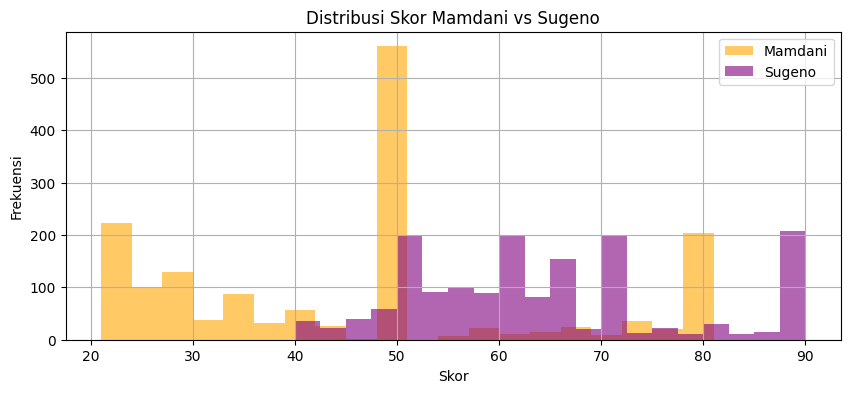

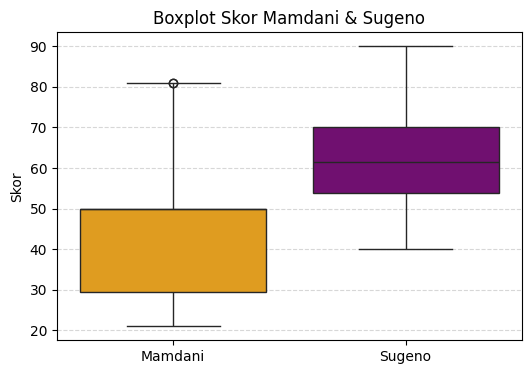

In [29]:
mamdani_scores = []
sugeno_scores = []

for _, row in df_filtered.iterrows():
    fz_alc = fuzzify_alcohol(row["alcohol"])
    fz_va = fuzzify_volatile_acidity(row["volatile acidity"])
    fz_sul = fuzzify_sulphates(row["sulphates"])

    mam_score = defuzzify_mamdani(mamdani_inference(fz_alc, fz_va, fz_sul))
    sug_score = sugeno_infer(fz_alc, fz_va, fz_sul)

    mamdani_scores.append(mam_score)
    sugeno_scores.append(sug_score)

# Gabungkan ke DataFrame
score_df = pd.DataFrame({
    "Mamdani": mamdani_scores,
    "Sugeno": sugeno_scores
})

# Statistik deskriptif
print(score_df.describe())

# Histogram
plt.figure(figsize=(10, 4))
plt.hist(score_df["Mamdani"], bins=20, alpha=0.6, label="Mamdani", color="orange")
plt.hist(score_df["Sugeno"], bins=20, alpha=0.6, label="Sugeno", color="purple")
plt.title("Distribusi Skor Mamdani vs Sugeno")
plt.xlabel("Skor")
plt.ylabel("Frekuensi")
plt.legend()
plt.grid(True)
plt.show()

# Boxplot
plt.figure(figsize=(6, 4))
sns.boxplot(data=score_df, palette=["orange", "purple"])
plt.title("Boxplot Skor Mamdani & Sugeno")
plt.ylabel("Skor")
plt.grid(True, axis="y", linestyle="--", alpha=0.5)
plt.show()
